# 06 - Baseline Models (SARIMA & Prophet)

This notebook trains and evaluates baseline time series models:

1. **SARIMA** - Seasonal ARIMA with grid search
2. **Prophet** - Facebook Prophet with seasonality
3. **Model Comparison** - Metrics and visualization

In [1]:
# Standard imports
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

# Project imports
from src.models.sarima import SARIMAModel, SARIMAConfig
from src.models.prophet_model import ProphetModel, ProphetConfig
from src.utils.metrics import evaluate_forecast, compare_models, print_metrics

# Configure plotting
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print(f"Project root: {project_root}")

LightGBM not installed. Install with: pip install lightgbm
Optuna not installed. Install with: pip install optuna
Project root: c:\Users\Admin\OneDrive\Documents\python\datafollow


## 1. Load Data

In [2]:
# Paths
DATA_DIR = project_root / "DATA"
PROCESSED_DIR = DATA_DIR / "processed"
MODELS_DIR = project_root / "models"
MODELS_DIR.mkdir(exist_ok=True)

# Load data
df_train = pd.read_parquet(PROCESSED_DIR / "train_features_5m.parquet")
df_test = pd.read_parquet(PROCESSED_DIR / "test_features_5m.parquet")

print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")
print(f"Train date range: {df_train['timestamp'].min()} to {df_train['timestamp'].max()}")
print(f"Test date range: {df_test['timestamp'].min()} to {df_test['timestamp'].max()}")

Train shape: (15264, 91)
Test shape: (2592, 91)
Train date range: 1995-07-01 00:00:00 to 1995-08-22 23:55:00
Test date range: 1995-08-23 00:00:00 to 1995-08-31 23:55:00


In [3]:
# Prepare time series data
TARGET = 'request_count'

# Set timestamp as index for SARIMA
train_ts = df_train.set_index('timestamp')[TARGET]
test_ts = df_test.set_index('timestamp')[TARGET]

print(f"Train series length: {len(train_ts)}")
print(f"Test series length: {len(test_ts)}")

Train series length: 15264
Test series length: 2592


In [4]:
# Use last 20% of training data for validation
val_size = int(len(train_ts) * 0.2)
train_ts_fit = train_ts[:-val_size]
val_ts = train_ts[-val_size:]

print(f"Training fit size: {len(train_ts_fit)}")
print(f"Validation size: {len(val_ts)}")

Training fit size: 12212
Validation size: 3052


## 2. SARIMA Model

### 2.1 Stationarity Test

In [5]:
# Test stationarity
stationarity = SARIMAModel.test_stationarity(train_ts_fit)

ADF Stationarity Test:
  ADF Statistic: -8.0764
  p-value: 0.0000
  Critical Values:
    1%: -3.4309
    5%: -2.8618
    10%: -2.5669
  Stationary: True


### 2.2 SARIMA Configuration

Based on the data:
- 5-minute aggregation: 12 periods = 1 hour
- Daily seasonality: 288 periods (but too large for SARIMA)
- Using hourly seasonality (m=12) as approximation

In [6]:
# SARIMA configuration
# Using hourly seasonality (12 periods of 5 minutes = 1 hour)
sarima_config = SARIMAConfig(
    order=(1, 1, 1),           # (p, d, q)
    seasonal_order=(1, 1, 1, 12),  # (P, D, Q, m) - hourly seasonality
    enforce_stationarity=False,
    enforce_invertibility=False,
)

print(f"SARIMA order: {sarima_config.order}")
print(f"Seasonal order: {sarima_config.seasonal_order}")

SARIMA order: (1, 1, 1)
Seasonal order: (1, 1, 1, 12)


In [7]:
# Optional: Grid search for best parameters (takes time)
# Uncomment to run grid search

# best_order, best_seasonal_order, best_aic = SARIMAModel.grid_search(
#     train_ts_fit,
#     p_range=range(0, 3),
#     d_range=range(0, 2),
#     q_range=range(0, 3),
#     P_range=range(0, 2),
#     D_range=range(0, 2),
#     Q_range=range(0, 2),
#     m=12,
#     criterion='aic',
# )
# print(f"\nBest order: {best_order}")
# print(f"Best seasonal order: {best_seasonal_order}")

### 2.3 Train SARIMA

In [8]:
# Create and fit SARIMA model
sarima_model = SARIMAModel(sarima_config)
sarima_model.fit(train_ts_fit)

# Print summary
print(sarima_model.summary())

Fitting SARIMA(1, 1, 1)x(1, 1, 1, 12)...


c:\Users\Admin\OneDrive\Documents\python\datafollow\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\Admin\OneDrive\Documents\python\datafollow\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


AIC: 130145.40
BIC: 130182.44
                                     SARIMAX Results                                      
Dep. Variable:                      request_count   No. Observations:                12212
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood              -65067.702
Date:                            Sat, 31 Jan 2026   AIC                         130145.404
Time:                                    15:45:55   BIC                         130182.444
Sample:                                07-01-1995   HQIC                        130157.820
                                     - 08-12-1995                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2454      0.007     37.606      0.000       0.233       0.258
ma.L1

### 2.4 SARIMA Validation

In [9]:
# Predict on validation set
sarima_val_pred, sarima_val_conf = sarima_model.predict(
    steps=len(val_ts),
    return_conf_int=True
)

# Evaluate
sarima_val_metrics = evaluate_forecast(val_ts.values, sarima_val_pred.values, name="SARIMA (Val)")
print_metrics(sarima_val_metrics)


Model: SARIMA (Val)
----------------------------------------
  RMSE:  148.3669
  MSE:   22012.7242
  MAE:   114.2917
  MAPE:  70.06%
  sMAPE: 82.85%
  R2:    -1.3039


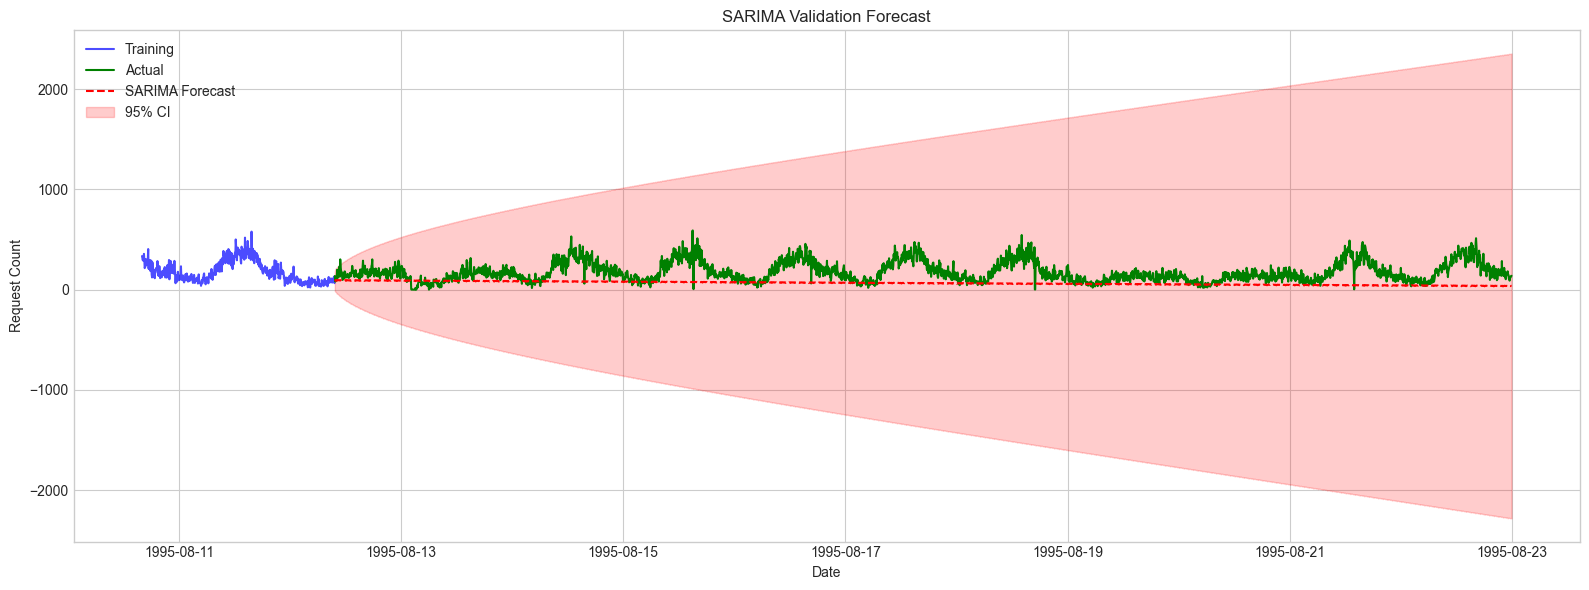

In [10]:
# Plot validation predictions
fig, ax = plt.subplots(figsize=(16, 6))

# Plot last portion of training data
plot_start = len(train_ts_fit) - 500
ax.plot(train_ts_fit.index[plot_start:], train_ts_fit.values[plot_start:], 
        label='Training', color='blue', alpha=0.7)

# Plot validation actual
ax.plot(val_ts.index, val_ts.values, label='Actual', color='green', linewidth=1.5)

# Plot predictions
ax.plot(val_ts.index, sarima_val_pred.values, label='SARIMA Forecast', 
        color='red', linestyle='--', linewidth=1.5)

# Confidence interval
ax.fill_between(val_ts.index, 
                sarima_val_conf.iloc[:, 0].values,
                sarima_val_conf.iloc[:, 1].values,
                color='red', alpha=0.2, label='95% CI')

ax.set_xlabel('Date')
ax.set_ylabel('Request Count')
ax.set_title('SARIMA Validation Forecast')
ax.legend()

plt.tight_layout()
plt.show()

### 2.5 Retrain on Full Training Set and Test

In [11]:
# Retrain on full training data
sarima_model_full = SARIMAModel(sarima_config)
sarima_model_full.fit(train_ts)

# Predict on test set
sarima_test_pred, sarima_test_conf = sarima_model_full.predict(
    steps=len(test_ts),
    return_conf_int=True
)

# Evaluate
sarima_test_metrics = evaluate_forecast(test_ts.values, sarima_test_pred.values, name="SARIMA (Test)")
print_metrics(sarima_test_metrics)

Fitting SARIMA(1, 1, 1)x(1, 1, 1, 12)...


c:\Users\Admin\OneDrive\Documents\python\datafollow\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)
c:\Users\Admin\OneDrive\Documents\python\datafollow\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 5min will be used.
  self._init_dates(dates, freq)


AIC: 162122.95
BIC: 162161.11

Model: SARIMA (Test)
----------------------------------------
  RMSE:  150.3689
  MSE:   22610.7942
  MAE:   108.5602
  MAPE:  58.51%
  sMAPE: 58.11%
  R2:    -0.5042


In [12]:
# Save SARIMA model
sarima_model_full.save(MODELS_DIR / "sarima_5m.pkl")

Model saved to c:\Users\Admin\OneDrive\Documents\python\datafollow\models\sarima_5m.pkl


## 3. Prophet Model

### 3.1 Prophet Configuration

In [13]:
# Prophet configuration
prophet_config = ProphetConfig(
    growth='linear',
    yearly_seasonality=False,  # Only ~2 months of data
    weekly_seasonality=True,   # Clear weekly pattern
    daily_seasonality=True,    # Clear daily pattern
    seasonality_mode='additive',
    changepoint_prior_scale=0.05,
    seasonality_prior_scale=10.0,
    interval_width=0.95,
)

print("Prophet Configuration:")
print(f"  Growth: {prophet_config.growth}")
print(f"  Weekly seasonality: {prophet_config.weekly_seasonality}")
print(f"  Daily seasonality: {prophet_config.daily_seasonality}")

Prophet Configuration:
  Growth: linear
  Weekly seasonality: True
  Daily seasonality: True


### 3.2 Prepare Data for Prophet

In [14]:
# Prepare data in Prophet format
train_prophet = ProphetModel.prepare_dataframe(df_train, 'timestamp', TARGET)
test_prophet = ProphetModel.prepare_dataframe(df_test, 'timestamp', TARGET)

# Split for validation
train_prophet_fit = train_prophet.iloc[:-val_size]
val_prophet = train_prophet.iloc[-val_size:]

print(f"Prophet train shape: {train_prophet_fit.shape}")
print(f"Prophet val shape: {val_prophet.shape}")
print(f"Prophet test shape: {test_prophet.shape}")

Prophet train shape: (12212, 2)
Prophet val shape: (3052, 2)
Prophet test shape: (2592, 2)


### 3.3 Train Prophet

In [ ]:
# Create and fit Prophet model
try:
    prophet_model = ProphetModel(prophet_config)
    prophet_model.fit(train_prophet_fit)
    PROPHET_AVAILABLE = True
except ImportError as e:
    print(f"Warning: {e}")
    print("Prophet model will be skipped. Install with: pip install prophet")
    PROPHET_AVAILABLE = False
    prophet_model = None
    prophet_val_metrics = {'model': 'Prophet (Val)', 'rmse': float('nan'), 'mae': float('nan'), 'mape': float('nan'), 'r2': float('nan')}
    prophet_test_metrics = {'model': 'Prophet (Test)', 'rmse': float('nan'), 'mae': float('nan'), 'mape': float('nan'), 'r2': float('nan')}

### 3.4 Prophet Validation

In [ ]:
# Predict on validation set
if PROPHET_AVAILABLE and prophet_model is not None:
    prophet_val_forecast = prophet_model.forecast(val_prophet[['ds']])

    # Extract predictions
    prophet_val_pred = prophet_val_forecast['yhat'].values

    # Evaluate
    prophet_val_metrics = evaluate_forecast(val_prophet['y'].values, prophet_val_pred, name="Prophet (Val)")
    print_metrics(prophet_val_metrics)
else:
    print("Prophet not available - skipping validation")

In [ ]:
# Plot validation predictions
if PROPHET_AVAILABLE and prophet_model is not None:
    fig, ax = plt.subplots(figsize=(16, 6))

    # Plot last portion of training data
    ax.plot(train_prophet_fit['ds'].iloc[-500:], train_prophet_fit['y'].iloc[-500:], 
            label='Training', color='blue', alpha=0.7)

    # Plot validation actual
    ax.plot(val_prophet['ds'], val_prophet['y'], label='Actual', color='green', linewidth=1.5)

    # Plot predictions
    ax.plot(prophet_val_forecast['ds'], prophet_val_forecast['yhat'], 
            label='Prophet Forecast', color='orange', linestyle='--', linewidth=1.5)

    # Confidence interval
    ax.fill_between(prophet_val_forecast['ds'], 
                    prophet_val_forecast['yhat_lower'],
                    prophet_val_forecast['yhat_upper'],
                    color='orange', alpha=0.2, label='95% CI')

    ax.set_xlabel('Date')
    ax.set_ylabel('Request Count')
    ax.set_title('Prophet Validation Forecast')
    ax.legend()

    plt.tight_layout()
    plt.show()
else:
    print("Prophet not available - skipping validation plot")

### 3.5 Prophet Components

In [ ]:
# Plot Prophet components
if PROPHET_AVAILABLE and prophet_model is not None:
    prophet_model.plot_components(figsize=(14, 10))
    plt.tight_layout()
    plt.show()
else:
    print("Prophet not available - skipping components plot")

### 3.6 Retrain on Full Training Set and Test

In [ ]:
# Retrain on full training data
if PROPHET_AVAILABLE:
    prophet_model_full = ProphetModel(prophet_config)
    prophet_model_full.fit(train_prophet)

    # Predict on test set
    prophet_test_forecast = prophet_model_full.forecast(test_prophet[['ds']])
    prophet_test_pred = prophet_test_forecast['yhat'].values

    # Evaluate
    prophet_test_metrics = evaluate_forecast(test_prophet['y'].values, prophet_test_pred, name="Prophet (Test)")
    print_metrics(prophet_test_metrics)
else:
    print("Prophet not available - skipping test evaluation")
    prophet_model_full = None
    prophet_test_pred = None

In [ ]:
# Save Prophet model
if PROPHET_AVAILABLE and prophet_model_full is not None:
    prophet_model_full.save(MODELS_DIR / "prophet_5m.pkl")
else:
    print("Prophet not available - model not saved")

## 4. Model Comparison

In [ ]:
# Compare validation results
metrics_list = [sarima_val_metrics]
if PROPHET_AVAILABLE:
    metrics_list.append(prophet_val_metrics)

val_comparison = compare_models(metrics_list)
print("\n=== VALIDATION SET COMPARISON ===")
print(val_comparison)

In [ ]:
# Compare test results
test_metrics_list = [sarima_test_metrics]
if PROPHET_AVAILABLE:
    test_metrics_list.append(prophet_test_metrics)

test_comparison = compare_models(test_metrics_list)
print("\n=== TEST SET COMPARISON ===")
print(test_comparison)

In [ ]:
# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Test set predictions comparison
ax = axes[0, 0]
ax.plot(test_ts.index, test_ts.values, label='Actual', color='green', linewidth=1)
ax.plot(test_ts.index, sarima_test_pred.values, label='SARIMA', color='red', alpha=0.7, linewidth=1)
ax.set_title('SARIMA vs Actual (Test Set)')
ax.legend()

ax = axes[0, 1]
ax.plot(test_ts.index, test_ts.values, label='Actual', color='green', linewidth=1)
if PROPHET_AVAILABLE and prophet_test_pred is not None:
    ax.plot(test_ts.index, prophet_test_pred, label='Prophet', color='orange', alpha=0.7, linewidth=1)
    ax.set_title('Prophet vs Actual (Test Set)')
else:
    ax.set_title('Prophet not available')
ax.legend()

# Residuals
sarima_residuals = test_ts.values - sarima_test_pred.values
ax = axes[1, 0]
ax.hist(sarima_residuals, bins=50, alpha=0.7, color='red', label='SARIMA')
if PROPHET_AVAILABLE and prophet_test_pred is not None:
    prophet_residuals = test_ts.values - prophet_test_pred
    ax.hist(prophet_residuals, bins=50, alpha=0.7, color='orange', label='Prophet')
ax.axvline(0, color='black', linestyle='--')
ax.set_title('Residual Distribution')
ax.set_xlabel('Residual')
ax.legend()

# Scatter: Actual vs Predicted
ax = axes[1, 1]
ax.scatter(test_ts.values, sarima_test_pred.values, alpha=0.3, label='SARIMA', s=5)
if PROPHET_AVAILABLE and prophet_test_pred is not None:
    ax.scatter(test_ts.values, prophet_test_pred, alpha=0.3, label='Prophet', s=5)
ax.plot([0, test_ts.max()], [0, test_ts.max()], 'k--', label='Perfect')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title('Actual vs Predicted')
ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Bar chart comparison of metrics
metrics_to_plot = ['rmse', 'mae', 'mape']
models = ['SARIMA']
colors_list = ['#E74C3C']
values_dict = {'SARIMA': sarima_test_metrics}

if PROPHET_AVAILABLE:
    models.append('Prophet')
    colors_list.append('#F39C12')
    values_dict['Prophet'] = prophet_test_metrics

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]
    values = [values_dict[m][metric] for m in models]
    bars = ax.bar(models, values, color=colors_list)
    ax.set_title(metric.upper())
    ax.set_ylabel('Value')
    
    # Add value labels
    for bar, val in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{val:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## 5. Summary

In [ ]:
print("=" * 60)
print("BASELINE MODELS SUMMARY")
print("=" * 60)

print("\n1. SARIMA MODEL")
print(f"   Order: {sarima_config.order}")
print(f"   Seasonal Order: {sarima_config.seasonal_order}")
print(f"   Test RMSE: {sarima_test_metrics['rmse']:.2f}")
print(f"   Test MAPE: {sarima_test_metrics['mape']:.2f}%")

if PROPHET_AVAILABLE:
    print("\n2. PROPHET MODEL")
    print(f"   Daily Seasonality: {prophet_config.daily_seasonality}")
    print(f"   Weekly Seasonality: {prophet_config.weekly_seasonality}")
    print(f"   Test RMSE: {prophet_test_metrics['rmse']:.2f}")
    print(f"   Test MAPE: {prophet_test_metrics['mape']:.2f}%")

    # Determine winner
    better_model = "SARIMA" if sarima_test_metrics['rmse'] < prophet_test_metrics['rmse'] else "Prophet"
    print(f"\n3. WINNER (by RMSE): {better_model}")
else:
    print("\n2. PROPHET MODEL")
    print("   Not available (install with: pip install prophet)")
    print("\n3. WINNER (by RMSE): SARIMA (only model available)")

print("\n4. SAVED MODELS")
print(f"   - {MODELS_DIR / 'sarima_5m.pkl'}")
if PROPHET_AVAILABLE:
    print(f"   - {MODELS_DIR / 'prophet_5m.pkl'}")

print("\n5. NEXT STEPS")
print("   - Train ML models (LightGBM) for potentially better results")
print("   - Compare all models and select best for production")

In [ ]:
# Save results for comparison with ML models
baseline_results = {
    'sarima_test': sarima_test_metrics,
    'sarima_val': sarima_val_metrics,
}

if PROPHET_AVAILABLE:
    baseline_results['prophet_test'] = prophet_test_metrics
    baseline_results['prophet_val'] = prophet_val_metrics

import json
with open(MODELS_DIR / 'baseline_results.json', 'w') as f:
    json.dump(baseline_results, f, indent=2)
    
print("Saved baseline results to models/baseline_results.json")

In [ ]:
print("\nNotebook completed successfully!")


Notebook completed successfully!
